
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh

____

# 🔴 **Import Libs**

In [1]:
!pip uninstall -y torch torchvision torchaudio torchtext torchdata
# Install specific versions of PyTorch and related packages with CUDA 11.7 support
!pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 torchaudio==2.0.2+cu117 -f https://download.pytorch.org/whl/cu117/torch_stable.html
# Install torchtext and torchdata
!pip install torchtext==0.15.2 torchdata==0.6.1
!pip install portalocker>==2.0.0

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in links: https://download.pytorch.org/whl/cu117/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 778.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 46.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [4]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.0.1+cu117
0.15.2+cpu


In [5]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.0.1+cu117
torchtext --> 0.15.2+cpu
tqdm --> 4.67.1


# 🔴 **Utils**

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [8]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [9]:
from datasets import load_dataset

# Load the WikiText2 dataset
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')

# Access train, validation, and test splits
train_dataset = dataset['train']
valid_dataset = dataset['validation']
test_dataset = dataset['test']

print("WikiText2 datasets loaded successfully.")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

WikiText2 datasets loaded successfully.
Train samples: 36718
Validation samples: 3760
Test samples: 4358


## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [10]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
import torch

# Define tokenizer
tokenizer = get_tokenizer('basic_english')

# Function to yield tokens from the dataset
def yield_tokens(dataset_split):
    for sample in dataset_split:
        yield tokenizer(sample['text'])

# Build vocabulary from the training data
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])

# Save the vocabulary for future use
torch.save(vocab, 'vocab.pth')

print("Vocabulary built and saved successfully.")
print(f"Vocabulary size: {len(vocab)}")



Vocabulary built and saved successfully.
Vocabulary size: 66061


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [11]:
# Number of documents
num_train_docs = len(train_dataset)
num_valid_docs = len(valid_dataset)
num_test_docs = len(test_dataset)

# Total words and average document length
def calculate_stats(dataset_split, split_name):
    total_words = 0
    for sample in dataset_split:
        tokens = tokenizer(sample['text'])
        total_words += len(tokens)
    avg_length = total_words / len(dataset_split)
    print(f"{split_name} - Number of documents: {len(dataset_split)}")
    print(f"{split_name} - Total words: {total_words}")
    print(f"{split_name} - Average document length: {avg_length:.2f} words\n")

calculate_stats(train_dataset, "Train")
calculate_stats(valid_dataset, "Validation")
calculate_stats(test_dataset, "Test")


Train - Number of documents: 36718
Train - Total words: 2051665
Train - Average document length: 55.88 words

Validation - Number of documents: 3760
Validation - Total words: 214665
Validation - Average document length: 57.09 words

Test - Number of documents: 4358
Test - Total words: 242156
Test - Average document length: 55.57 words



### 🟡 Analyze the most common and least common words in the dataset.

In [12]:
from collections import Counter

# Get word frequencies
counter = Counter()
for sample in train_dataset:
    tokens = tokenizer(sample['text'])
    counter.update(tokens)

# Most common 10 words
print("Most Common 10 Words:")
for word, freq in counter.most_common(10):
    print(f"{word}: {freq}")
print()

# Least common 10 words (excluding singletons)
least_common = [word for word, freq in counter.items() if freq > 1]
least_common = sorted(least_common, key=lambda x: counter[x])[:10]
print("Least Common 10 Words (Frequency > 1):")
for word in least_common:
    print(f"{word}: {counter[word]}")


Most Common 10 Words:
the: 130770
,: 102624
.: 84291
of: 57032
and: 50736
in: 45018
to: 39522
a: 36564
=: 29570
was: 21008

Least Common 10 Words (Frequency > 1):
raita: 2
valkyira: 2
heroines: 2
boons: 2
lancers: 2
deserters: 2
exonerating: 2
valkyrian: 2
trump: 2
anew: 2


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

###Vocabulary Size Distribution

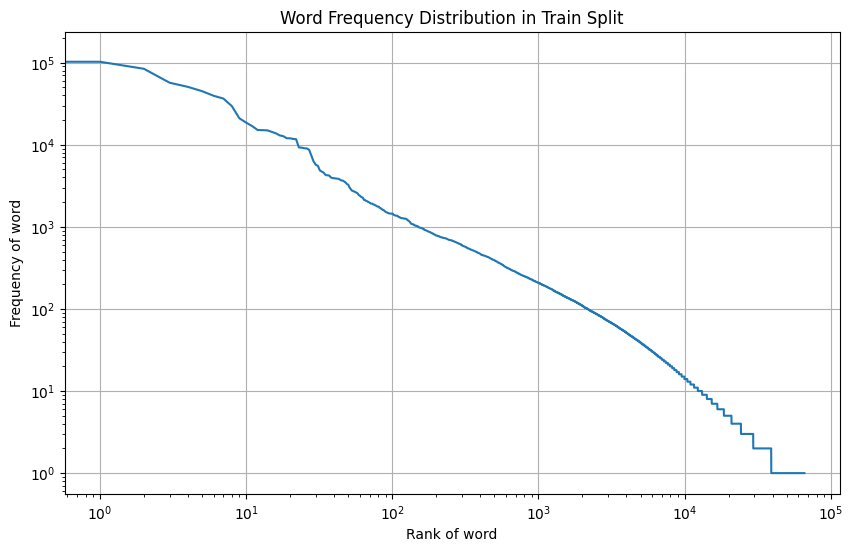

In [13]:
import matplotlib.pyplot as plt

word_freq = sorted(counter.values(), reverse=True)
plt.figure(figsize=(10,6))
plt.loglog(word_freq)
plt.title('Word Frequency Distribution in Train Split')
plt.xlabel('Rank of word')
plt.ylabel('Frequency of word')
plt.grid(True)
plt.show()


###Sentence Length Distribution:

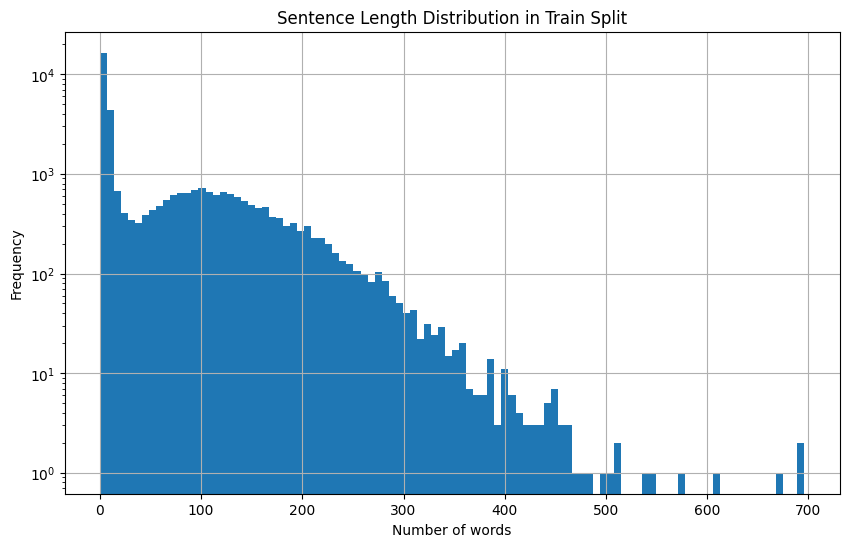

In [14]:
import matplotlib.pyplot as plt

sentence_lengths = [len(tokenizer(sample['text'])) for sample in train_dataset]
plt.figure(figsize=(10,6))
plt.hist(sentence_lengths, bins=100, log=True)
plt.title('Sentence Length Distribution in Train Split')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [15]:
import math

# Hyperparameters
batch_size = 20
seq_len = 35

# Function to process raw text into batched tensors
def data_process(dataset_split, vocab, batch_size, seq_len):
    # Convert all text to numerical indices with <bos> and <eos> tokens
    data = []
    for sample in dataset_split:
        tokens = tokenizer(sample['text'])
        data.extend([vocab['<bos>']] + [vocab[token] for token in tokens] + [vocab['<eos>']])

    # Convert to tensor
    data_tensor = torch.tensor(data, dtype=torch.long)

    # Calculate the number of batches
    num_batches = data_tensor.size(0) // (batch_size * seq_len)

    # Trim data to fit
    data_tensor = data_tensor[:num_batches * batch_size * seq_len]

    # Reshape data
    data_tensor = data_tensor.view(batch_size, -1)

    inputs = data_tensor[:, :-1].contiguous()
    targets = data_tensor[:, 1:].contiguous()

    return inputs, targets

# Process train, validation, and test datasets
train_inputs, train_targets = data_process(train_dataset, vocab, batch_size, seq_len)
valid_inputs, valid_targets = data_process(valid_dataset, vocab, batch_size, seq_len)
test_inputs, test_targets = data_process(test_dataset, vocab, batch_size, seq_len)

print("Data processing complete.")
print(f"Train Inputs Shape: {train_inputs.shape}")
print(f"Train Targets Shape: {train_targets.shape}")


Data processing complete.
Train Inputs Shape: torch.Size([20, 106224])
Train Targets Shape: torch.Size([20, 106224])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [16]:
from torch.utils.data import DataLoader, Dataset

# Custom Dataset
class LanguageModelDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.size(1)  # Number of sequences

    def __getitem__(self, idx):
        return self.inputs[:, idx], self.targets[:, idx]

# Create Dataset instances
train_data = LanguageModelDataset(train_inputs, train_targets)
valid_data = LanguageModelDataset(valid_inputs, valid_targets)
test_data = LanguageModelDataset(test_inputs, test_targets)


## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [26]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

print("DataLoaders created successfully.")

DataLoaders created successfully.


# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [18]:
from torch import nn

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, src, hidden=None):
        embedded = self.dropout(self.embedding(src))  # (batch_size, seq_len, embedding_dim)
        output, hidden = self.lstm(embedded, hidden)  # output: (batch_size, seq_len, hidden_dim)
        output = self.dropout(output)
        output = output.reshape(-1, output.size(2))  # (batch_size * seq_len, hidden_dim)
        logits = self.fc(output)  # (batch_size * seq_len, vocab_size)
        return logits, hidden



# 🔴 **Config**

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [27]:
# Model hyperparameters
vocab_size = len(vocab)
embedding_dim = 200
hidden_dim = 200
num_layers = 2
dropout_rate = 0.2

# Instantiate the model
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print number of trainable parameters
def num_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6

print(f"Model has {num_trainable_params(model):.2f}M trainable parameters")


Model has 27.13M trainable parameters


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [28]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    model.train()
    loss_train = AverageMeter()
    metric.reset()

    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for batch_idx, (inputs, targets) in enumerate(tepoch):
            if epoch is not None:
                tepoch.set_description(f'Epoch {epoch}')

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs, _ = model(inputs)
            loss = loss_fn(outputs, targets.view(-1))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item(), n=targets.numel())
            metric.update(outputs, targets.view(-1))

            tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

    return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [22]:
def evaluate(model, valid_loader, loss_fn, metric):
    model.eval()
    loss_eval = AverageMeter()
    metric.reset()

    with torch.inference_mode():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs, _ = model(inputs)
            loss = loss_fn(outputs, targets.view(-1))

            loss_eval.update(loss.item(), n=targets.numel())
            metric.update(outputs, targets.view(-1))

    return loss_eval.avg, metric.compute().item()

In [23]:
import tqdm
import torchmetrics as tm

# AverageMeter class to track metrics
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [29]:
# Define hyperparameters for the model
vocab_size = len(vocab)
embedding_dim = 200
hidden_dim = 200
num_layers = 2
dropout_rate = 0.2

# Initialize the model
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer (initial learning rate will be updated later)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define the metric with the correct initialization
metric = tm.Accuracy(task='multiclass', num_classes=vocab_size).to(device)

# Get a batch from the training set
train_loader_iter = iter(train_loader)
inputs, targets = next(train_loader_iter)

# Move inputs and targets to the device
inputs = inputs.to(device)
targets = targets.to(device)

# Calculate loss for the untrained model
with torch.no_grad():
    outputs, _ = model(inputs)
    loss = loss_fn(outputs, targets.view(-1))

print(f'Loss for untrained model: {loss.item():.4f}')


Loss for untrained model: 11.0971


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [30]:
# Define a small subset size
subset_size = 512  # Adjust as needed

# Create a subset DataLoader
from torch.utils.data import Subset

subset_indices = list(range(subset_size))
train_subset = Subset(train_data, subset_indices)
train_subset_loader = DataLoader(train_subset, batch_size=1, shuffle=True)

# Initialize a new model for the subset
model_subset = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

# Define optimizer for the subset
optimizer_subset = torch.optim.SGD(model_subset.parameters(), lr=0.01, momentum=0.9)

# Define metric for the subset
metric_subset = tm.Accuracy(task='multiclass', num_classes=vocab_size).to(device)

# Number of epochs for overfitting
num_epochs_subset = 20

# Training loop for the subset
for epoch in range(1, num_epochs_subset + 1):
    model_subset, loss_train, metric_train = train_one_epoch(
        model_subset,
        train_subset_loader,
        loss_fn,
        optimizer_subset,
        metric_subset,
        epoch
    )
    print(f'Epoch {epoch}/{num_epochs_subset} - Train Loss: {loss_train:.4f}, Train Accuracy: {metric_train:.4f}')


Epoch 1: 100%|██████████| 512/512 [00:07<00:00, 70.78batch/s, loss=9.66, metric=0.0539]


Epoch 1/20 - Train Loss: 9.6606, Train Accuracy: 0.0539


Epoch 2: 100%|██████████| 512/512 [00:06<00:00, 75.98batch/s, loss=7.75, metric=0.0525]


Epoch 2/20 - Train Loss: 7.7548, Train Accuracy: 0.0525


Epoch 3: 100%|██████████| 512/512 [00:07<00:00, 71.98batch/s, loss=7.27, metric=0.0507]


Epoch 3/20 - Train Loss: 7.2728, Train Accuracy: 0.0507


Epoch 4: 100%|██████████| 512/512 [00:06<00:00, 75.77batch/s, loss=7.01, metric=0.0562]


Epoch 4/20 - Train Loss: 7.0093, Train Accuracy: 0.0562


Epoch 5: 100%|██████████| 512/512 [00:07<00:00, 71.38batch/s, loss=6.81, metric=0.0673]


Epoch 5/20 - Train Loss: 6.8112, Train Accuracy: 0.0673


Epoch 6: 100%|██████████| 512/512 [00:06<00:00, 76.40batch/s, loss=6.63, metric=0.0868]


Epoch 6/20 - Train Loss: 6.6278, Train Accuracy: 0.0868


Epoch 7: 100%|██████████| 512/512 [00:07<00:00, 71.59batch/s, loss=6.48, metric=0.0954]


Epoch 7/20 - Train Loss: 6.4753, Train Accuracy: 0.0954


Epoch 8: 100%|██████████| 512/512 [00:06<00:00, 75.95batch/s, loss=6.36, metric=0.103]


Epoch 8/20 - Train Loss: 6.3579, Train Accuracy: 0.1029


Epoch 9: 100%|██████████| 512/512 [00:07<00:00, 71.33batch/s, loss=6.27, metric=0.106]


Epoch 9/20 - Train Loss: 6.2693, Train Accuracy: 0.1056


Epoch 10: 100%|██████████| 512/512 [00:06<00:00, 75.94batch/s, loss=6.18, metric=0.114]


Epoch 10/20 - Train Loss: 6.1768, Train Accuracy: 0.1142


Epoch 11: 100%|██████████| 512/512 [00:07<00:00, 70.02batch/s, loss=6.09, metric=0.116]


Epoch 11/20 - Train Loss: 6.0908, Train Accuracy: 0.1162


Epoch 12: 100%|██████████| 512/512 [00:06<00:00, 74.26batch/s, loss=6.01, metric=0.122]


Epoch 12/20 - Train Loss: 6.0096, Train Accuracy: 0.1216


Epoch 13: 100%|██████████| 512/512 [00:08<00:00, 63.59batch/s, loss=5.94, metric=0.124]


Epoch 13/20 - Train Loss: 5.9355, Train Accuracy: 0.1240


Epoch 14: 100%|██████████| 512/512 [00:06<00:00, 77.04batch/s, loss=5.87, metric=0.128]


Epoch 14/20 - Train Loss: 5.8743, Train Accuracy: 0.1279


Epoch 15: 100%|██████████| 512/512 [00:07<00:00, 71.33batch/s, loss=5.81, metric=0.125]


Epoch 15/20 - Train Loss: 5.8081, Train Accuracy: 0.1254


Epoch 16: 100%|██████████| 512/512 [00:06<00:00, 76.58batch/s, loss=5.73, metric=0.133]


Epoch 16/20 - Train Loss: 5.7330, Train Accuracy: 0.1331


Epoch 17: 100%|██████████| 512/512 [00:07<00:00, 71.73batch/s, loss=5.67, metric=0.135]


Epoch 17/20 - Train Loss: 5.6681, Train Accuracy: 0.1348


Epoch 18: 100%|██████████| 512/512 [00:06<00:00, 78.36batch/s, loss=5.6, metric=0.142]


Epoch 18/20 - Train Loss: 5.6047, Train Accuracy: 0.1425


Epoch 19: 100%|██████████| 512/512 [00:06<00:00, 73.55batch/s, loss=5.55, metric=0.141]


Epoch 19/20 - Train Loss: 5.5501, Train Accuracy: 0.1414


Epoch 20: 100%|██████████| 512/512 [00:06<00:00, 75.57batch/s, loss=5.47, metric=0.15]

Epoch 20/20 - Train Loss: 5.4698, Train Accuracy: 0.1496


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [32]:
# Define hyperparameters to explore
learning_rates = [0.1, 0.01, 0.001]
num_epochs_lr = 2  # Number of epochs per learning rate

# Store results
lr_results = []

for lr in learning_rates:
    print(f'\nTraining with learning rate: {lr}')

    # Initialize a new model for each learning rate
    model_lr = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

    # Define optimizer with current learning rate
    optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=lr, momentum=0.9)

    # Define metric
    metric_lr = tm.Accuracy(task='multiclass', num_classes=vocab_size).to(device)

    # Training loop
    for epoch in range(1, num_epochs_lr + 1):
        model_lr, loss_train, metric_train = train_one_epoch(
            model_lr,
            train_loader,
            loss_fn,
            optimizer_lr,
            metric_lr,
            epoch
        )
        print(f'Epoch {epoch}/{num_epochs_lr} - Train Loss: {loss_train:.4f}, Train Accuracy: {metric_train:.4f}')

    # Evaluate on validation set
    loss_valid, metric_valid = evaluate(model_lr, valid_loader, loss_fn, metric_lr)
    print(f'Validation Loss: {loss_valid:.4f}, Validation Accuracy: {metric_valid:.4f}')

    # Record results
    lr_results.append({
        'learning_rate': lr,
        'train_loss': loss_train,
        'train_accuracy': metric_train,
        'valid_loss': loss_valid,
        'valid_accuracy': metric_valid
    })



Training with learning rate: 0.1


Epoch 1: 100%|██████████| 1660/1660 [01:31<00:00, 18.16batch/s, loss=7.11, metric=0.118]


Epoch 1/2 - Train Loss: 7.1059, Train Accuracy: 0.1181


Epoch 2: 100%|██████████| 1660/1660 [01:31<00:00, 18.22batch/s, loss=6.59, metric=0.139]


Epoch 2/2 - Train Loss: 6.5864, Train Accuracy: 0.1394
Validation Loss: 6.5237, Validation Accuracy: 0.1556

Training with learning rate: 0.01


Epoch 1: 100%|██████████| 1660/1660 [01:32<00:00, 17.98batch/s, loss=8.41, metric=0.0604]


Epoch 1/2 - Train Loss: 8.4055, Train Accuracy: 0.0604


Epoch 2: 100%|██████████| 1660/1660 [01:31<00:00, 18.20batch/s, loss=7.32, metric=0.0961]


Epoch 2/2 - Train Loss: 7.3228, Train Accuracy: 0.0961
Validation Loss: 7.1123, Validation Accuracy: 0.1203

Training with learning rate: 0.001


Epoch 1: 100%|██████████| 1660/1660 [01:31<00:00, 18.18batch/s, loss=10.9, metric=0.058]


Epoch 1/2 - Train Loss: 10.8763, Train Accuracy: 0.0580


Epoch 2: 100%|██████████| 1660/1660 [01:31<00:00, 18.06batch/s, loss=9.1, metric=0.0608]


Epoch 2/2 - Train Loss: 9.1007, Train Accuracy: 0.0608
Validation Loss: 8.5317, Validation Accuracy: 0.0663


### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [33]:
best_lr = 0.1
weight_decays = [1e-4, 1e-5, 1e-6]
num_epochs_wd = 1  # Number of epochs per weight decay

# Store results
wd_results = []

for wd in weight_decays:
    print(f'\nTraining with learning rate: {best_lr}, weight decay: {wd}')

    # Initialize a new model for each weight decay
    model_wd = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

    # Define optimizer with current weight decay
    optimizer_wd = torch.optim.SGD(model_wd.parameters(), lr=best_lr, weight_decay=wd, momentum=0.9)

    # Define metric
    metric_wd = tm.Accuracy(task='multiclass', num_classes=vocab_size).to(device)

    # Training loop
    for epoch in range(1, num_epochs_wd + 1):
        model_wd, loss_train, metric_train = train_one_epoch(
            model_wd,
            train_loader,
            loss_fn,
            optimizer_wd,
            metric_wd,
            epoch
        )
        print(f'Epoch {epoch}/{num_epochs_wd} - Train Loss: {loss_train:.4f}, Train Accuracy: {metric_train:.4f}')

    # Evaluate on validation set
    loss_valid, metric_valid = evaluate(model_wd, valid_loader, loss_fn, metric_wd)
    print(f'Validation Loss: {loss_valid:.4f}, Validation Accuracy: {metric_valid:.4f}')

    # Record results
    wd_results.append({
        'weight_decay': wd,
        'train_loss': loss_train,
        'train_accuracy': metric_train,
        'valid_loss': loss_valid,
        'valid_accuracy': metric_valid
    })



Training with learning rate: 0.1, weight decay: 0.0001


Epoch 1: 100%|██████████| 1660/1660 [01:35<00:00, 17.46batch/s, loss=7.13, metric=0.116]


Epoch 1/1 - Train Loss: 7.1274, Train Accuracy: 0.1158
Validation Loss: 6.7031, Validation Accuracy: 0.1409

Training with learning rate: 0.1, weight decay: 1e-05


Epoch 1: 100%|██████████| 1660/1660 [01:34<00:00, 17.64batch/s, loss=7.11, metric=0.118]


Epoch 1/1 - Train Loss: 7.1089, Train Accuracy: 0.1176
Validation Loss: 6.6636, Validation Accuracy: 0.1410

Training with learning rate: 0.1, weight decay: 1e-06


Epoch 1: 100%|██████████| 1660/1660 [01:33<00:00, 17.67batch/s, loss=7.11, metric=0.118]


Epoch 1/1 - Train Loss: 7.1068, Train Accuracy: 0.1181
Validation Loss: 6.6755, Validation Accuracy: 0.1426


### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [34]:
best_wd = 1e-5

# Initialize the final model with best hyperparameters
model_final = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

# Define optimizer with best hyperparameters
optimizer_final = torch.optim.SGD(
    model_final.parameters(),
    lr=best_lr,
    weight_decay=best_wd,
    momentum=0.9,
    nesterov=True
)

# Define metric
metric_final = tm.Accuracy(task='multiclass', num_classes=vocab_size).to(device)

# Initialize training history lists
loss_train_hist = []
loss_valid_hist = []
metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

# Define number of epochs for final training
num_epochs_final = 50

for epoch in range(1, num_epochs_final + 1):
    # Train
    model_final, loss_train, metric_train = train_one_epoch(
        model_final,
        train_loader,
        loss_fn,
        optimizer_final,
        metric_final,
        epoch
    )

    # Validate
    loss_valid, metric_valid = evaluate(
        model_final,
        valid_loader,
        loss_fn,
        metric_final
    )

    # Record history
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)

    # Save the best model based on validation loss
    if loss_valid < best_loss_valid:
        torch.save(model_final.state_dict(), 'model.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'Epoch {epoch}/{num_epochs_final} - Train Loss: {loss_train:.4f}, Train Accuracy: {metric_train:.4f}')
    print(f'Validation Loss: {loss_valid:.4f}, Validation Accuracy: {metric_valid:.4f}\n')

    epoch_counter += 1


Epoch 1: 100%|██████████| 1660/1660 [01:37<00:00, 17.05batch/s, loss=7.09, metric=0.119]


Model Saved!
Epoch 1/50 - Train Loss: 7.0906, Train Accuracy: 0.1189
Validation Loss: 6.6656, Validation Accuracy: 0.1422



Epoch 2: 100%|██████████| 1660/1660 [01:36<00:00, 17.28batch/s, loss=6.6, metric=0.139]


Model Saved!
Epoch 2/50 - Train Loss: 6.5983, Train Accuracy: 0.1392
Validation Loss: 6.5349, Validation Accuracy: 0.1517



Epoch 3: 100%|██████████| 1660/1660 [01:36<00:00, 17.13batch/s, loss=6.49, metric=0.147]


Model Saved!
Epoch 3/50 - Train Loss: 6.4869, Train Accuracy: 0.1470
Validation Loss: 6.4522, Validation Accuracy: 0.1603



Epoch 4: 100%|██████████| 1660/1660 [01:36<00:00, 17.26batch/s, loss=6.41, metric=0.153]


Model Saved!
Epoch 4/50 - Train Loss: 6.4148, Train Accuracy: 0.1527
Validation Loss: 6.3963, Validation Accuracy: 0.1680



Epoch 5: 100%|██████████| 1660/1660 [01:36<00:00, 17.22batch/s, loss=6.36, metric=0.157]


Model Saved!
Epoch 5/50 - Train Loss: 6.3611, Train Accuracy: 0.1566
Validation Loss: 6.3557, Validation Accuracy: 0.1695



Epoch 6: 100%|██████████| 1660/1660 [01:36<00:00, 17.26batch/s, loss=6.32, metric=0.159]


Model Saved!
Epoch 6/50 - Train Loss: 6.3188, Train Accuracy: 0.1592
Validation Loss: 6.3201, Validation Accuracy: 0.1728



Epoch 7: 100%|██████████| 1660/1660 [01:36<00:00, 17.26batch/s, loss=6.28, metric=0.161]


Model Saved!
Epoch 7/50 - Train Loss: 6.2832, Train Accuracy: 0.1609
Validation Loss: 6.2948, Validation Accuracy: 0.1741



Epoch 8: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.25, metric=0.162]


Model Saved!
Epoch 8/50 - Train Loss: 6.2543, Train Accuracy: 0.1624
Validation Loss: 6.2769, Validation Accuracy: 0.1758



Epoch 9: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.23, metric=0.163]


Model Saved!
Epoch 9/50 - Train Loss: 6.2289, Train Accuracy: 0.1635
Validation Loss: 6.2626, Validation Accuracy: 0.1756



Epoch 10: 100%|██████████| 1660/1660 [01:36<00:00, 17.28batch/s, loss=6.21, metric=0.164]


Model Saved!
Epoch 10/50 - Train Loss: 6.2076, Train Accuracy: 0.1645
Validation Loss: 6.2462, Validation Accuracy: 0.1777



Epoch 11: 100%|██████████| 1660/1660 [01:36<00:00, 17.26batch/s, loss=6.19, metric=0.166]


Model Saved!
Epoch 11/50 - Train Loss: 6.1878, Train Accuracy: 0.1655
Validation Loss: 6.2360, Validation Accuracy: 0.1767



Epoch 12: 100%|██████████| 1660/1660 [01:36<00:00, 17.26batch/s, loss=6.17, metric=0.166]


Model Saved!
Epoch 12/50 - Train Loss: 6.1708, Train Accuracy: 0.1660
Validation Loss: 6.2240, Validation Accuracy: 0.1743



Epoch 13: 100%|██████████| 1660/1660 [01:36<00:00, 17.24batch/s, loss=6.16, metric=0.167]


Model Saved!
Epoch 13/50 - Train Loss: 6.1550, Train Accuracy: 0.1666
Validation Loss: 6.2171, Validation Accuracy: 0.1793



Epoch 14: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.14, metric=0.167]


Model Saved!
Epoch 14/50 - Train Loss: 6.1398, Train Accuracy: 0.1674
Validation Loss: 6.2076, Validation Accuracy: 0.1793



Epoch 15: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.13, metric=0.168]


Model Saved!
Epoch 15/50 - Train Loss: 6.1259, Train Accuracy: 0.1677
Validation Loss: 6.1998, Validation Accuracy: 0.1741



Epoch 16: 100%|██████████| 1660/1660 [01:36<00:00, 17.22batch/s, loss=6.11, metric=0.168]


Model Saved!
Epoch 16/50 - Train Loss: 6.1129, Train Accuracy: 0.1685
Validation Loss: 6.1936, Validation Accuracy: 0.1797



Epoch 17: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.1, metric=0.169]


Model Saved!
Epoch 17/50 - Train Loss: 6.1002, Train Accuracy: 0.1688
Validation Loss: 6.1890, Validation Accuracy: 0.1801



Epoch 18: 100%|██████████| 1660/1660 [01:36<00:00, 17.24batch/s, loss=6.09, metric=0.169]


Model Saved!
Epoch 18/50 - Train Loss: 6.0896, Train Accuracy: 0.1693
Validation Loss: 6.1859, Validation Accuracy: 0.1765



Epoch 19: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.08, metric=0.17]


Model Saved!
Epoch 19/50 - Train Loss: 6.0779, Train Accuracy: 0.1697
Validation Loss: 6.1756, Validation Accuracy: 0.1807



Epoch 20: 100%|██████████| 1660/1660 [01:36<00:00, 17.28batch/s, loss=6.07, metric=0.17]


Model Saved!
Epoch 20/50 - Train Loss: 6.0663, Train Accuracy: 0.1700
Validation Loss: 6.1704, Validation Accuracy: 0.1801



Epoch 21: 100%|██████████| 1660/1660 [01:36<00:00, 17.29batch/s, loss=6.06, metric=0.17]


Model Saved!
Epoch 21/50 - Train Loss: 6.0553, Train Accuracy: 0.1703
Validation Loss: 6.1679, Validation Accuracy: 0.1804



Epoch 22: 100%|██████████| 1660/1660 [01:36<00:00, 17.23batch/s, loss=6.04, metric=0.171]


Model Saved!
Epoch 22/50 - Train Loss: 6.0447, Train Accuracy: 0.1709
Validation Loss: 6.1670, Validation Accuracy: 0.1809



Epoch 23: 100%|██████████| 1660/1660 [01:36<00:00, 17.27batch/s, loss=6.03, metric=0.171]


Model Saved!
Epoch 23/50 - Train Loss: 6.0344, Train Accuracy: 0.1710
Validation Loss: 6.1640, Validation Accuracy: 0.1794



Epoch 24: 100%|██████████| 1660/1660 [01:36<00:00, 17.26batch/s, loss=6.02, metric=0.171]


Model Saved!
Epoch 24/50 - Train Loss: 6.0247, Train Accuracy: 0.1714
Validation Loss: 6.1604, Validation Accuracy: 0.1739



Epoch 25: 100%|██████████| 1660/1660 [01:36<00:00, 17.24batch/s, loss=6.02, metric=0.172]


Model Saved!
Epoch 25/50 - Train Loss: 6.0158, Train Accuracy: 0.1716
Validation Loss: 6.1558, Validation Accuracy: 0.1768



Epoch 26: 100%|██████████| 1660/1660 [01:36<00:00, 17.23batch/s, loss=6.01, metric=0.172]


Model Saved!
Epoch 26/50 - Train Loss: 6.0063, Train Accuracy: 0.1722
Validation Loss: 6.1528, Validation Accuracy: 0.1818



Epoch 28: 100%|██████████| 1660/1660 [01:36<00:00, 17.17batch/s, loss=5.99, metric=0.172]


Model Saved!
Epoch 28/50 - Train Loss: 5.9895, Train Accuracy: 0.1725
Validation Loss: 6.1497, Validation Accuracy: 0.1814



Epoch 29: 100%|██████████| 1660/1660 [01:36<00:00, 17.13batch/s, loss=5.98, metric=0.173]


Model Saved!
Epoch 29/50 - Train Loss: 5.9805, Train Accuracy: 0.1729
Validation Loss: 6.1486, Validation Accuracy: 0.1819



Epoch 30: 100%|██████████| 1660/1660 [01:36<00:00, 17.16batch/s, loss=5.97, metric=0.173]


Model Saved!
Epoch 30/50 - Train Loss: 5.9723, Train Accuracy: 0.1728
Validation Loss: 6.1464, Validation Accuracy: 0.1780



Epoch 31: 100%|██████████| 1660/1660 [01:36<00:00, 17.24batch/s, loss=5.96, metric=0.173]


Model Saved!
Epoch 31/50 - Train Loss: 5.9649, Train Accuracy: 0.1732
Validation Loss: 6.1435, Validation Accuracy: 0.1820



Epoch 32: 100%|██████████| 1660/1660 [01:36<00:00, 17.22batch/s, loss=5.96, metric=0.174]


Model Saved!
Epoch 32/50 - Train Loss: 5.9565, Train Accuracy: 0.1737
Validation Loss: 6.1431, Validation Accuracy: 0.1823



Epoch 33: 100%|██████████| 1660/1660 [01:36<00:00, 17.19batch/s, loss=5.95, metric=0.174]


Model Saved!
Epoch 33/50 - Train Loss: 5.9484, Train Accuracy: 0.1736
Validation Loss: 6.1399, Validation Accuracy: 0.1806



Epoch 34: 100%|██████████| 1660/1660 [01:36<00:00, 17.20batch/s, loss=5.94, metric=0.174]


Epoch 34/50 - Train Loss: 5.9411, Train Accuracy: 0.1736
Validation Loss: 6.1399, Validation Accuracy: 0.1824



Epoch 35: 100%|██████████| 1660/1660 [01:36<00:00, 17.18batch/s, loss=5.93, metric=0.174]


Model Saved!
Epoch 35/50 - Train Loss: 5.9341, Train Accuracy: 0.1742
Validation Loss: 6.1372, Validation Accuracy: 0.1820



Epoch 36: 100%|██████████| 1660/1660 [01:36<00:00, 17.21batch/s, loss=5.93, metric=0.174]


Epoch 36/50 - Train Loss: 5.9267, Train Accuracy: 0.1743
Validation Loss: 6.1386, Validation Accuracy: 0.1820



Epoch 37: 100%|██████████| 1660/1660 [01:36<00:00, 17.20batch/s, loss=5.92, metric=0.175]


Model Saved!
Epoch 37/50 - Train Loss: 5.9198, Train Accuracy: 0.1745
Validation Loss: 6.1349, Validation Accuracy: 0.1832



Epoch 38: 100%|██████████| 1660/1660 [01:36<00:00, 17.19batch/s, loss=5.91, metric=0.175]


Model Saved!
Epoch 38/50 - Train Loss: 5.9129, Train Accuracy: 0.1749
Validation Loss: 6.1340, Validation Accuracy: 0.1824



Epoch 39: 100%|██████████| 1660/1660 [01:36<00:00, 17.18batch/s, loss=5.91, metric=0.175]


Epoch 39/50 - Train Loss: 5.9061, Train Accuracy: 0.1748
Validation Loss: 6.1342, Validation Accuracy: 0.1828



Epoch 40: 100%|██████████| 1660/1660 [01:36<00:00, 17.19batch/s, loss=5.9, metric=0.175]


Model Saved!
Epoch 40/50 - Train Loss: 5.8994, Train Accuracy: 0.1754
Validation Loss: 6.1319, Validation Accuracy: 0.1823



Epoch 41: 100%|██████████| 1660/1660 [01:36<00:00, 17.18batch/s, loss=5.89, metric=0.176]


Epoch 41/50 - Train Loss: 5.8932, Train Accuracy: 0.1755
Validation Loss: 6.1330, Validation Accuracy: 0.1841



Epoch 42: 100%|██████████| 1660/1660 [01:36<00:00, 17.21batch/s, loss=5.89, metric=0.176]


Model Saved!
Epoch 42/50 - Train Loss: 5.8866, Train Accuracy: 0.1759
Validation Loss: 6.1286, Validation Accuracy: 0.1838



Epoch 43: 100%|██████████| 1660/1660 [01:36<00:00, 17.15batch/s, loss=5.88, metric=0.176]


Model Saved!
Epoch 43/50 - Train Loss: 5.8810, Train Accuracy: 0.1757
Validation Loss: 6.1274, Validation Accuracy: 0.1827



Epoch 44: 100%|██████████| 1660/1660 [01:36<00:00, 17.19batch/s, loss=5.87, metric=0.176]


Model Saved!
Epoch 44/50 - Train Loss: 5.8750, Train Accuracy: 0.1760
Validation Loss: 6.1241, Validation Accuracy: 0.1824



Epoch 45: 100%|██████████| 1660/1660 [01:36<00:00, 17.17batch/s, loss=5.87, metric=0.176]


Epoch 45/50 - Train Loss: 5.8686, Train Accuracy: 0.1764
Validation Loss: 6.1267, Validation Accuracy: 0.1827



Epoch 46: 100%|██████████| 1660/1660 [01:36<00:00, 17.20batch/s, loss=5.86, metric=0.177]


Epoch 46/50 - Train Loss: 5.8627, Train Accuracy: 0.1766
Validation Loss: 6.1279, Validation Accuracy: 0.1833



Epoch 47: 100%|██████████| 1660/1660 [01:36<00:00, 17.21batch/s, loss=5.86, metric=0.177]


Model Saved!
Epoch 47/50 - Train Loss: 5.8571, Train Accuracy: 0.1767
Validation Loss: 6.1241, Validation Accuracy: 0.1836



Epoch 48: 100%|██████████| 1660/1660 [01:36<00:00, 17.19batch/s, loss=5.85, metric=0.177]


Model Saved!
Epoch 48/50 - Train Loss: 5.8504, Train Accuracy: 0.1771
Validation Loss: 6.1231, Validation Accuracy: 0.1830



Epoch 49: 100%|██████████| 1660/1660 [01:36<00:00, 17.13batch/s, loss=5.85, metric=0.177]


Epoch 49/50 - Train Loss: 5.8451, Train Accuracy: 0.1772
Validation Loss: 6.1238, Validation Accuracy: 0.1841



Epoch 50: 100%|██████████| 1660/1660 [01:37<00:00, 17.08batch/s, loss=5.84, metric=0.178]


Model Saved!
Epoch 50/50 - Train Loss: 5.8391, Train Accuracy: 0.1775
Validation Loss: 6.1189, Validation Accuracy: 0.1835



## 🟠 Main Loop

🔰 Define model.

In [35]:
# Initialize the final model with best hyperparameters
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)


🔰 Define optimizer and Set learning rate and weight decay.

In [36]:
best_lr = 0.01
best_wd = 1e-4

# Define optimizer with best hyperparameters
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=best_lr,
    weight_decay=best_wd,
    momentum=0.9,
    nesterov=True
)

🔰 Write code to train the model for `num_epochs` epoches.

In [37]:
# Define metric
metric = tm.Accuracy(task='multiclass', num_classes=vocab_size).to(device)

# Initialize training history lists
loss_train_hist = []
loss_valid_hist = []
metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

# Define number of epochs
num_epochs = 15  # Adjust as needed

for epoch in range(1, num_epochs + 1):
    # Train
    model, loss_train, metric_train = train_one_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        metric,
        epoch
    )

    # Validate
    loss_valid, metric_valid = evaluate(
        model,
        valid_loader,
        loss_fn,
        metric
    )

    # Record history
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)

    # Save the best model based on validation loss
    if loss_valid < best_loss_valid:
        torch.save(model.state_dict(), 'model.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'Epoch {epoch}/{num_epochs} - Train Loss: {loss_train:.4f}, Train Accuracy: {metric_train:.4f}')
    print(f'Validation Loss: {loss_valid:.4f}, Validation Accuracy: {metric_valid:.4f}\n')

    epoch_counter += 1


Epoch 1: 100%|██████████| 1660/1660 [01:37<00:00, 17.11batch/s, loss=8.41, metric=0.0615]


Model Saved!
Epoch 1/15 - Train Loss: 8.4142, Train Accuracy: 0.0615
Validation Loss: 7.5474, Validation Accuracy: 0.0845



Epoch 2: 100%|██████████| 1660/1660 [01:36<00:00, 17.23batch/s, loss=7.32, metric=0.098]


Model Saved!
Epoch 2/15 - Train Loss: 7.3202, Train Accuracy: 0.0980
Validation Loss: 7.1090, Validation Accuracy: 0.1231



Epoch 3: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=7.05, metric=0.121]


Model Saved!
Epoch 3/15 - Train Loss: 7.0529, Train Accuracy: 0.1209
Validation Loss: 6.9499, Validation Accuracy: 0.1288



Epoch 4: 100%|██████████| 1660/1660 [01:36<00:00, 17.27batch/s, loss=6.93, metric=0.126]


Model Saved!
Epoch 4/15 - Train Loss: 6.9302, Train Accuracy: 0.1261
Validation Loss: 6.8639, Validation Accuracy: 0.1322



Epoch 5: 100%|██████████| 1660/1660 [01:36<00:00, 17.26batch/s, loss=6.86, metric=0.129]


Model Saved!
Epoch 5/15 - Train Loss: 6.8573, Train Accuracy: 0.1286
Validation Loss: 6.8104, Validation Accuracy: 0.1351



Epoch 6: 100%|██████████| 1660/1660 [01:36<00:00, 17.24batch/s, loss=6.81, metric=0.131]


Model Saved!
Epoch 6/15 - Train Loss: 6.8067, Train Accuracy: 0.1307
Validation Loss: 6.7715, Validation Accuracy: 0.1376



Epoch 7: 100%|██████████| 1660/1660 [01:36<00:00, 17.24batch/s, loss=6.77, metric=0.132]


Model Saved!
Epoch 7/15 - Train Loss: 6.7690, Train Accuracy: 0.1322
Validation Loss: 6.7425, Validation Accuracy: 0.1384



Epoch 8: 100%|██████████| 1660/1660 [01:36<00:00, 17.24batch/s, loss=6.74, metric=0.133]


Model Saved!
Epoch 8/15 - Train Loss: 6.7394, Train Accuracy: 0.1331
Validation Loss: 6.7198, Validation Accuracy: 0.1370



Epoch 9: 100%|██████████| 1660/1660 [01:36<00:00, 17.24batch/s, loss=6.71, metric=0.134]


Model Saved!
Epoch 9/15 - Train Loss: 6.7148, Train Accuracy: 0.1336
Validation Loss: 6.6981, Validation Accuracy: 0.1383



Epoch 10: 100%|██████████| 1660/1660 [01:36<00:00, 17.24batch/s, loss=6.69, metric=0.135]


Model Saved!
Epoch 10/15 - Train Loss: 6.6941, Train Accuracy: 0.1345
Validation Loss: 6.6834, Validation Accuracy: 0.1390



Epoch 11: 100%|██████████| 1660/1660 [01:36<00:00, 17.20batch/s, loss=6.68, metric=0.136]


Model Saved!
Epoch 11/15 - Train Loss: 6.6761, Train Accuracy: 0.1355
Validation Loss: 6.6683, Validation Accuracy: 0.1400



Epoch 12: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.66, metric=0.137]


Model Saved!
Epoch 12/15 - Train Loss: 6.6600, Train Accuracy: 0.1365
Validation Loss: 6.6567, Validation Accuracy: 0.1414



Epoch 13: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.65, metric=0.137]


Model Saved!
Epoch 13/15 - Train Loss: 6.6456, Train Accuracy: 0.1373
Validation Loss: 6.6420, Validation Accuracy: 0.1407



Epoch 14: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.63, metric=0.138]


Model Saved!
Epoch 14/15 - Train Loss: 6.6327, Train Accuracy: 0.1380
Validation Loss: 6.6301, Validation Accuracy: 0.1425



Epoch 15: 100%|██████████| 1660/1660 [01:36<00:00, 17.25batch/s, loss=6.62, metric=0.139]


Model Saved!
Epoch 15/15 - Train Loss: 6.6204, Train Accuracy: 0.1388
Validation Loss: 6.6219, Validation Accuracy: 0.1445



## 🟠 Plot

🔰 Plot learning curves

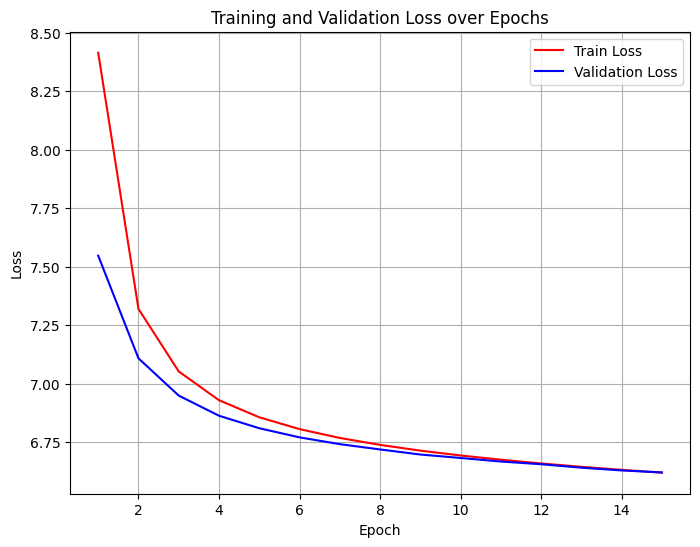

In [38]:
plt.figure(figsize=(8, 6))

plt.plot(range(1, epoch_counter +1), loss_train_hist, 'r-', label='Train Loss')
plt.plot(range(1, epoch_counter +1), loss_valid_hist, 'b-', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.grid(True)
plt.legend()

plt.show()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [39]:
# Load the best model
model.load_state_dict(torch.load('model.pt'))
model.eval()

# Define metric for testing
metric_test = tm.Accuracy(task='multiclass', num_classes=vocab_size).to(device)

# Evaluate on test set
loss_test, metric_test_value = evaluate(
    model,
    test_loader,
    loss_fn,
    metric_test
)

print(f'Test Loss: {loss_test:.4f}, Test Accuracy: {metric_test_value:.4f}')


Test Loss: 6.6602, Test Accuracy: 0.1419


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [40]:
# Load the best model
model_path = 'model.pt'
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()



LanguageModel(
  (embedding): Embedding(66061, 200)
  (lstm): LSTM(200, 200, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=200, out_features=66061, bias=True)
)

In [41]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    if seed:
        torch.manual_seed(seed)

    model.eval()
    tokens = tokenizer(prompt)
    input_ids = torch.tensor([vocab['<bos>']] + [vocab[token] for token in tokens], dtype=torch.long).unsqueeze(0).to(device)

    generated = input_ids.tolist()[0]

    hidden = None
    for _ in range(max_seq_len):
        with torch.no_grad():
            outputs, hidden = model(input_ids, hidden)
            outputs = outputs / temperature
            probabilities = F.softmax(outputs[-1], dim=0).cpu()
            next_token = torch.multinomial(probabilities, 1).item()
            generated.append(next_token)
            input_ids = torch.tensor([[next_token]], dtype=torch.long).to(device)
            if next_token == vocab['<eos>']:
                break

    generated_tokens = [vocab.lookup_token(token_id) for token_id in generated]
    return ' '.join(generated_tokens)


In [42]:
# Example usage:
prompt = "The meaning of life is"
generated_text = generate(
    prompt=prompt,
    max_seq_len=50,
    temperature=1.0,
    model=model,
    tokenizer=tokenizer,
    vocab=vocab,
    seed=42
)
print("Generated Text:")
print(generated_text)

Generated Text:
<bos> the meaning of life is an 220 , that the companion clarifies which was reached success her heavy field , = <eos>
